<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0825_NPLM(2003).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving nnlm7.png to nnlm7.png
User uploaded file "nnlm7.png" with length 95195 bytes


In [58]:
from IPython.display import Image

# 1. INTRO  

&nbsp;&nbsp;&nbsp;&nbsp;확률적 언어 모델[NPLM](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)(Neural Probabilistic Language Model)은 이전 word sequences를 통해 다음 word sequences를 예측하는 것이다. (이것은 최근들어 'NNLM' (Neural Networks Language Models)라고 불리기도 한다.)


## 1.1 도입 동기  
  
 === 언어 모델링을 어렵게 만드는 문제: **차원의 저주**  ===
  
 기존의 언어 모델링에서, #(Input words)가 증가하면,  #(Param)은 기하급수적으로 커진다. 이 곤경은 기존의 **원-핫 인코딩** 방법에서 자주 나타난다.  


### 1.1.1 원핫 인코딩  
  
&nbsp;&nbsp;&nbsp;&nbsp;일종의 Discrete representation(혹은 Localist representation)인 원핫 인코딩은 각 단어에 인덱스를 부여하는 희소 벡터를 할당하는 방법이다. 단어 words 집합(vocabulary) --- which is 서로 다른 단어들의 집합 --- 안에 아래 같이 3 개의 words가 있다고 해보자.  

사과: [1 0 0]  
배: [0 1 0]  
복숭아: [0 0 1]  

In [ ]:
# For 1.1.1

import numpy as np

words = ['사과','배','복숭아']
onehot_vectors = []

for i in range(len(words)):

    onehot_vectors.append(i)


for i in range(len(onehot_vectors)):

    print( (words[i], np.eye(len(onehot_vectors))[i]))

('사과', array([1., 0., 0.]))
('배', array([0., 1., 0.]))
('복숭아', array([0., 0., 1.]))


### 1.1.2 원핫 인코딩이 가진 곤경  
  
(1) 원핫 인코딩에서, Input words의 수가 크게 늘어난다면, 가령 그 수가 1 만개라면, 각각의 단어 벡터들은 희소 벡터 형태를 가진 1 만 차원의 벡터가 되는데, 이것은 메모리 효율과 계산 복잡도 차원에서 **비효율적**이다.  우리는 Input words의 개수가 늘어나더라도 더 효율적으로 이 words를 처리할 필요가 있다.
  
(2) 원핫 인코딩의 경우에, 단어들의 **유사성을** **비교하기** **어렵다.** 위 사례에서 보듯이, 두 개의 단어 벡터들 간의 dot product는 항상 0 이기 때문이다. 이 사실은 두 벡터 간의 cosine 관계가 직교 orthogonal 한다는 것을 의미하고, 이는 두 원핫 벡터가 서로 연관이 없다는 것을 함의한다. 하지만 이것은 문제적이다. 왜냐하면 **각** **벡터와** **연결된** **단어들** **간의** **상관성**이 있을 수 있기 때문이다. 예컨대, 우리는 단어 '강아지'와 '고양이'가 서로 금수라는 측면에서 유사하다고 간주할 수 있고, 단어 '낙관적인'과 '비관적인'은 서로 반의어 관계에 있다는 것을 받아들일 수 있다.

In [ ]:
# For 1.1.2.(2)
a = [1,0,0]
b=[0,1,0]
result = 0

for i in range(3):

    result += a[i]*b[i]

print(result)

0


## 1.2 분산 표현 Distributed Representations  
  
본고에서는 분산 표현을 통해 언어 모델링을 하고자 한다. 즉, 이것은 분산 표현을 통해 이전 단어 시퀀스를 가지고 다음에 나올 단어 시퀀스를 예측하고자 한다. 여기서 [분산 표현을 사용하는 이유]는 이것을 도입하면 (1) 기존의 언어 모델링 때 나타나는 차원의 저주가 다소 해소되고, 뿐만 아니라 (2) 단어들 간의 유사성 비교도 가능해지기 때문이다.  
분산 표현 distributed representations은 ---- 원핫 인코딩 경우와 같이 단어와 벡터 간의 one to one 관계가 아닌 ---- 이들 간의 many to many 관계에 의해 표현된다. 즉, 분산 표현에서는 어떤 단일의 concept(word)의 표현이라도 여러 processing units에 대해 분포된다. 대개 이 units의 벡터값은 1, 0 이 아닌 연속적인 값(실수)이다. 이것은 소위 'anti-localist'라 불리는 connectionist (McClelland, Hinton et al.)에 의해 옹호되었다. 아래 그림은 분산 표현에 대한 사례를 보여준다.  


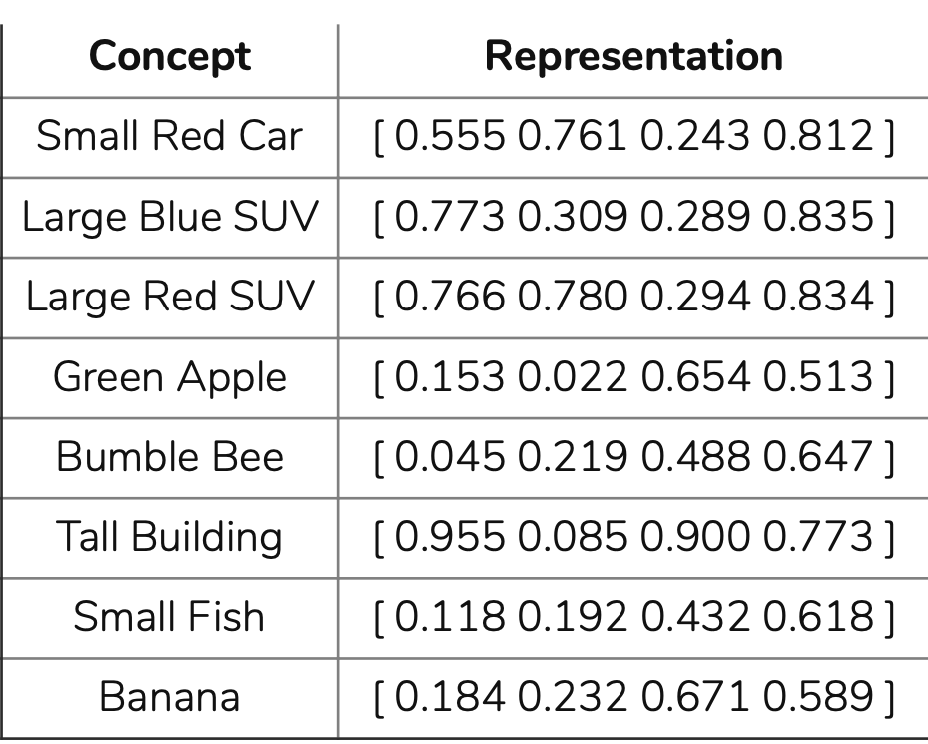

In [ ]:
Image('nnlm1.png',width=600)

이 분산 표현을 이용하면 우리는 1.1.2에서 살펴보았던 원핫 인코딩(localist 표현)이 갖는 2 가지 곤경을 모두 어느 정도 해소할 수 있다.  
  
(1') 분산 표현에서는 words가 사상된 (processing unit vectors인) **word feature vectors**을 통해 **단어** **시퀀스의** **결합 확률 함수 joint probability function**를 표현한다. 이것은 words와 feature vectors가 many to many 관계에 있게 만들어 준다. 이것이 차원의 저주를 해소하는 까닭은 Feature vectors의 수가 words의 수보다 훨씬 작기 때문이다. *이 Feature vectors는 단어의 여러 측면을 표현하기 때문에* 원핫 인코딩 경우처럼 words의 수에 비례한 많은 unit vector를 필요로 하지 않는다.  
  
(2') 분산 표현에서는 단어 간의 유사도를 비교할 수 있다. [[원핫 인코딩]]에서는 가령 '곰'과 '사자'가 유사한 정도와 '사자'와 '바나나'가 유사한 정도가 같았다면, [[분산 표현]]에서는 이제 그렇지 않다. 위의 사례 그림을 볼 때, 우리는 Red SUV와 Blue SUV의 유사성 정도는 그것들과 Small Fish 간의 유사성 정도 보다 더 크다는 것을 알 수 있고, 이 귀결은 우리의 직관과 잘 부합한다고 말해질 수 있다.

## 1.3 이전 작업들과의 연관  
  
학습된 시퀀스의 일반화로부터 new 시퀀스를 얻기 위한 words 간의 유사성 비교는 **새로운** **것이** **아니다.**

### 1.3.1 조건적 확률의 곱으로 표현된 신경망 사용  
  
신경망NN을 사용하는 것은 "각각의 랜덤 변수가 다양한 nature를 갖는 집합 Z1, ... Zn"의 결합 확률을 학습하는 데 유용하다는 것은 이미 잘 알려져 있다. 하지만 우리 모델에서 이 결합 확률은 **조건적**  **확률의** **곱**으로 분해된다:  
  

$$\hat{P}(Z_1 = z_1, ..., Z_n = z_n) = \prod_i \hat{P}(Z_i = z_i|g_i(Z_{i-1}, Z_{i-2} = z_{i-2}, ..., Z_1 = z_1))$$
  
  

여기서 $g(.)$는, 임의의 order에서, 이전 Z의 값($Z_{i-1})$을 고려할 때 $Z_i$의 **조건적** **확률의** **분포**를 계산해준다

#### 1.3.1.1 어떻게 자연 언어가 조건적 확률의 곱으로 표현되는가? (예시)  
  
$P(``Attitude\ is\ everything``)$을 문장 $``Attitude\ is\ everything``$에 대한 확률이라고 해보자. 그리고 이 문장 내의 단어들을 다음 같이 스플릿해보자:   
  
- $P(``Attitude``,\ ``is``,\ ``everything``)$  

Given that the conditional probability principle $P(A,B)=P(A|B)P(B)$,   
- $P(A|B,C)\ =\ \frac{P(A,B,C)}{P(B,C)}$  

Furthermore, by this conclusion, it follows that   
- $P(A,B,C)=P(A|B,C)*P(B,C)=P(A|B,C)*P(B|C)*P(C)$ where $(A, B) = (A \And B)$  
  
  

So, we can regard   
  
- $P(``Attitude\ is\ everything``)$ $=$ $P(``everything``|``is``,``Attitude``)*P(``is``|``Attitude``)*P(``Attitude``)$ in the same form above.

### 1.3.2 매개 변수 공유  
  
- 매개 변수 공유 across input words at different positions   

> 제안된 이 모델은 $w_1, w_2, ...$와 같이 각 단어가 입력되는 시간이 지나도 동일한 매개변수를 공유한다 


### 1.3.3 연속적인 실수 벡터 사용  
  
- 이전 작업들에서는 대개 이산 랜덤 (또는 deterministic) 변수를 사용하여 단어들 간의 유사성을 비교하고자 했다. 하지만 우리 모델에서는 이것을 수행하기 위해 (학습된 분산 특징 벡터 같은) 연속적인 실수real 벡터를 사용한다.

# 2. 신경망 모델  
  


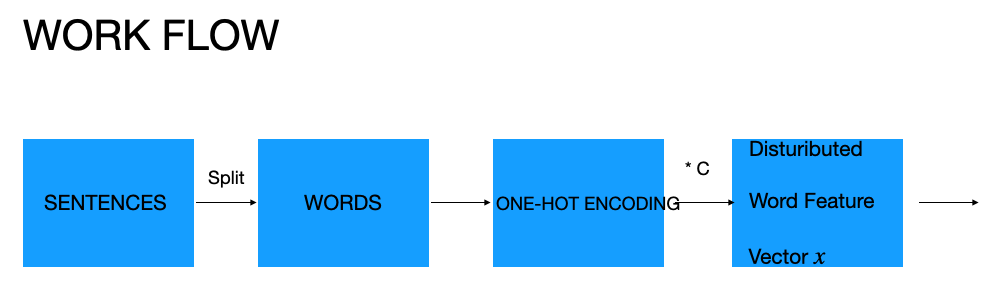

In [ ]:
Image('nnlm8.png',width=600)

## 2.1 준비  
  
- 트레이닝 셋: 시퀀스 $w_1, ..., w_T$ of $w_t \in V$ where V is large but finite set.  
  
- 목표: 적당한 모델에게 높은 표본외out of sample 가능도를 부여하기 위해 $f(w_t, ..., w_{t-n+1}) = \hat{P}(w_t|w_1^{t-1})$을 학습시키는 것  
  
- 개략적인 과정: $f = C$와 $g$의 합성 함수:  
  
 (1) **$C$**: word를 distributed feature vector로 사상mapping  

 (2) **$g$**: distributed feature vectors의 input sequence인 $x$를 다음 단어 $w_t$에 대한 조건적 확률로 사상

### 2.1.1  

  
위 식은 다시 $f(w_t, ..., w_{t-n+1}) = g(i, C(w_{t-1}), ..., C(w_{t-n+1}))$로 표현된다.   

- 제약: $\sum_{i=1}^{|V|} f(w_t, ..., w_{t-n+1})=1$ 
  

  
(1) 함수 $C$:  
- V의 임의의 원소 $i$ $\to$ $C(i) \in R^m$. 여기서 $i$는 a word  
- 이 함수는 V 내의 각 word와 연관된 **Distributed** **feature** **vectors** 를 표현한다.  
- C는 모든 context 내의 words에 대해 공유된다. (매개변수 공유)  

- $C^{|V| x m}$인 free parameters.    
  
(2) 단어에 대한 확률 함수 $g$:  
  
- Context 내의 단어의 feature vector의 입력 시퀀스: $$((C(w_{t-n+1}), ..., C(w_{t-1}))$$
  
- 다음에 나올 단어 $w_t$에 대한 V 내의 words의 조건적 확률 분포:  
  $$\hat{P}(w_t = i | w_1^{t-1})$$  
    
- The function $g$ is this: $$g: ((C(w_{t-t+1}), ..., C(w_{t-1})) \to \hat{P}(w_t = i | w_1^{t-1})$$  
  


(3) Thus, it follows that  $$f(w_t, ..., w_{t-n+1}) = \hat{P}(w_t|w_1^{t-1})$$

## 2.2 트레이닝  
  
위 2.1 에서의 작업들은 아래 그림과 같이 요약될 수 있다. 우리는 위에서 더 나아가 트레이닝을 통해 $\theta = (C, \omega)\ \ where\ \ \omega\ \ is\ \ parameters$인 $\theta$를 찾고자 한다. 이 $\theta$는 the training corpus penalized log-likelihood를 최대화하는 변수이다.

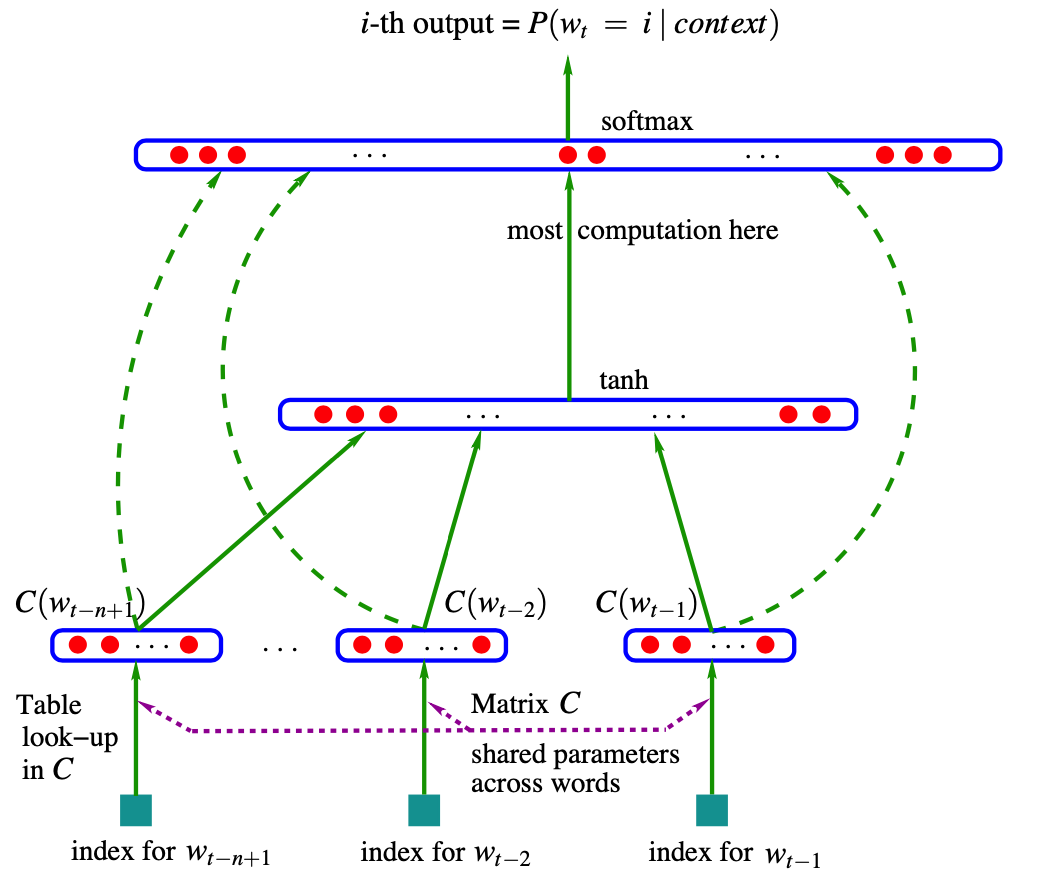

In [ ]:
Image('n2.png',width = 600)

### 2.2.1 Loss & output  

Notice that 이전의 모든 word를 input으로 넣지 않고, 오직 n - 1  개의 이전 words만을 Input으로 간주한다는 점에 주목.
- Loss:  
$$ L = \frac{1}{T} \sum_i log\ f(w_t, w_{t-1}, ..., w_{t-n+1}; \theta) + R(\theta)$$  
  
- 총합이 1인 softmax output:  

$$\hat{P}(w_t|w_{t-1}, ..., w_{t-n+1}) = \frac{e^{y_{wt}}}{\sum_i e^{y_i}}$$  
 
> 위 식에서 $y_i$는 $y=b + Wx + U\ tanh(d+Hx)$로 계산된 각 output 단어 i에 대한 unnormalized 로그 확률이다.  $(b,W, U, H)$는 매개변수.  
  


### 2.2.2 Introductory remarks  

  

* $tanh$ 는 원소 by 원소로 적용된다  
* $W$는 선택적으로 0  
* $x$는 행렬 C로부터 input word features의 연결이다:  
$$x = (C(w_{t-1}), ..., C(w_{t-n+1}))$$  
  
* $h$는 은닉층 개수  
* $m$은 각 단어와 연관된 features의 개수    

* $b$는 (|V|개의 원소를 가진) output bias 
* $d$는 (h 개의 원소를 가진) 은닉층 bias
* $U^{|V| * h}$는 hidden -- output 가중치 
* $W^{|V|* (n-1)m}$은 word features -- ouput 가중치  
* $H^{h* (n-1)m}$은 은닉층 가중치  
* $C^{|V|*m}$는 word features   
  
* 자유 매개변수의 개수: $|V|(1+mn+h)+h(1+(n-1)m)$ 


#### 2.2.2.1 문장 토큰화, V 구하기

In [ ]:
import numpy as np


sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))

V = len(word_list)
print(V)

15


#### 2.2.2.2 변수 설정 및 초기화

In [ ]:
n = 2 # # number of steps, n-1 in paper
h = 2 # 은닉층 개수
m = 2 # 각 단어와 연관된 features의 개수 (임베딩 사이즈)


self.C = nn.Linear(V, m, bias=False) # "shared word features layer C, which has no non-linearity"
self.H = nn.Linear(h,n * m, bias=False)
self.d = nn.Parameter(torch.ones(h))
self.U = nn.Linear(V,h, bias=False)
self.W = nn.Linear(V,n*m, bias=False)
self.b = nn.Parameter(torch.ones(V))

### 2.2.3 Note  
 
- 이론적으로, C를 제외하고 W, H에만 weight decay가 있으면, W, H는 0을 향해 수렴하는 반면에, C는 blow up 된다. 하지만 실제에서 우리는 Stochastic gradient ascent를 가지고 트레이닝을 할 때 그런 양상을 관찰하지 못한다. 

## 2.3 병렬 처리  
  
> 병렬 컴퓨터로 이 모델을 수행하는 것은 연산 시간을 줄이는 하나의 방법이다.
  
(1) 데이터 병렬 처리  
  
각 프로세서는 해당 data의 다른 subset을 가지고 수행한다.  
  
(2) Parameter 병렬 처리  
  
다른 CPU들에서 해당 모델의 output unit의 매개변수를 병렬 처리 한다.

## 2.4 업데이트

- SGA 확률적 경사 상승법

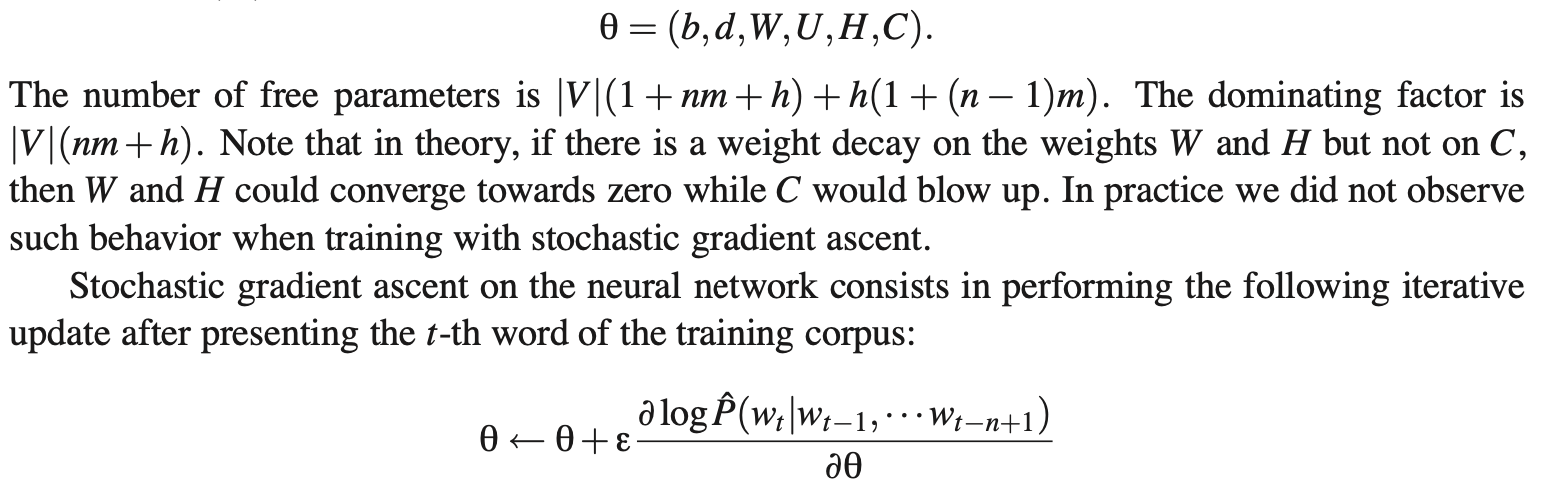

In [ ]:
Image('nnlm5.png',width=600)

# 3. Implementation

## 3.1 

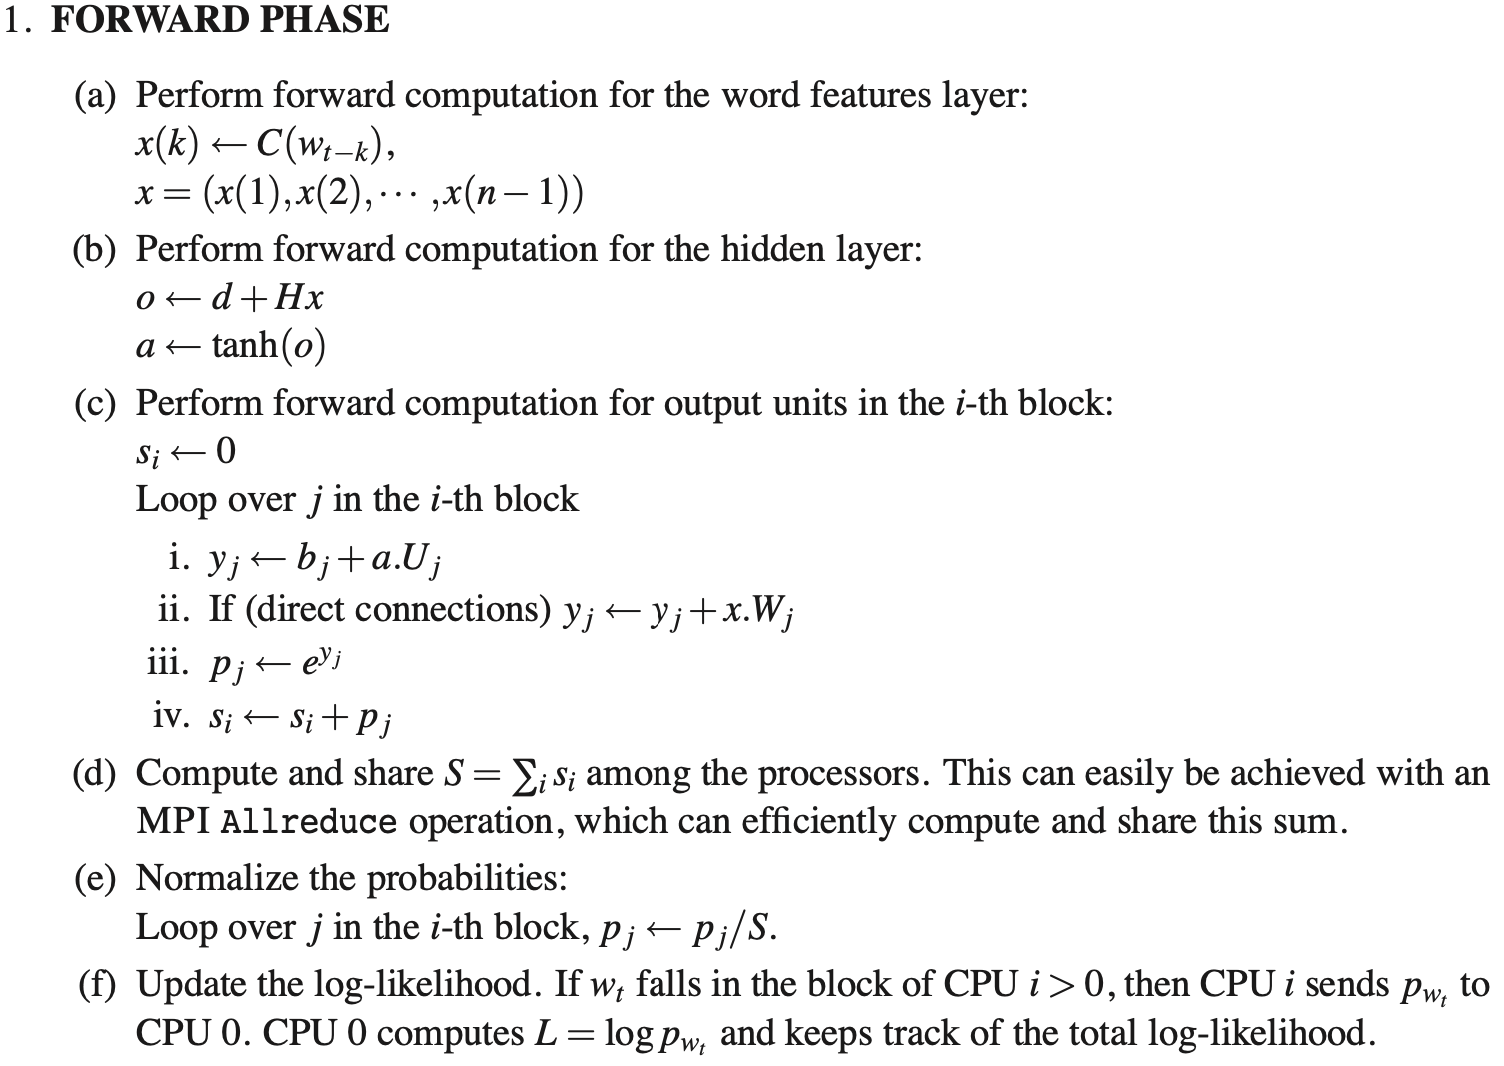

In [ ]:
Image('n3.png',width=600)

#### 3.1.0 one_hot_encoding 벡터와 C를 이용하여 word_feature_vector 구하기 ( 위 논문의 $x$ 구하기)

- (1) one_hot_encoded vector [B, V] 
- (2) word_feature_matrix [V,E], corresponding to $C$ in the paper

- (3) np.dot(one_hot_encoded vector, word_feature_matrix)

In [ ]:
import numpy as np
from copy import deepcopy

sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list)) # 중복 단어 없애기 위해 set 사용 
V = len(word_list) # 15 개

# (1) Output indices of the each word

  # (1-1) dict으로 구하기

char_to_integer = dict((i, c) for c, i in enumerate(word_list))
print('(1) 각 word의 index: ',char_to_integer) # check

  # (1-2) list를 이용하여 각 단어의 index 구하기

word_to_integer = list(i for i in range(V))
print('\n(2) word to integer: ', word_to_integer)    

# (2) Making onehot_vectors for the word_list

onehot_vector = list() # 초기화
onehot_vectors_set = list()

for i in word_to_integer: # 위에서 만든 word_to_integer를 하나씩 loop
    
    del onehot_vector[:] # word_to_integer의 loop를 돌 때마다 리스트 내의 데이터가 초기화
    
    for index in range(V): # 단어의 개수 만큼 돌면서, 증가하는 index가 word_to_integer loop에서 돌고 있는 Index와 동일할 때에만, 각각의 onehot_vector 리스트 내에 1을 추가, 그렇지 않으면 0 추가.
        
        if word_to_integer[i] == index:
        
            onehot_vector.append(1)

        else:
            onehot_vector.append(0)

    onehot_vectors_set.append(deepcopy(onehot_vector)) # 한번의 loop 마다 만들어지는 각각의 onehot_vector를 그것을 묶을 list 형태의 set에 추가
                                                       # deepcopy에 대한 더 자세한 이해는 아래의 reference[6]를 참고하라.
    

#(3) Making "word_features_vectors"

onehot_vectors_set = np.array(onehot_vectors_set) # matmul 연산을 위해 set을 array화 해준다, 15 x 15

print("\n(3-1) onehot_vectors_set\n\n",onehot_vectors_set)
C = np.random.rand(V, m) # random_feature_matrix, V=15, m = 2

word_features_vectors = np.matmul(onehot_vectors_set, C) # 이것을 lookup table 과정이라고 부르기도 한다.
print('\n(3-2) X which is the word_features_vector: \n\n',word_features_vectors, '\n\n * 교훈: shared word feature matrix인 C를 사용함으로써 차원의 저주를 다소 해소할 수 있다','\n')
print('(4) shape이 줄어든다:',onehot_vectors_set.shape,'===>',word_features_vectors.shape)
X = word_features_vectors


(1) 각 word의 index:  {'The': 0, 'on': 1, 'But': 2, 'the': 3, 'dislike': 4, 'to': 5, 'engineering': 6, 'mathematics': 7, 'many': 8, 'study': 9, 'is': 10, 'based': 11, 'students': 12, 'Many': 13, 'want': 14}

(2) word to integer:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

(3-1) onehot_vectors_set

 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

(3-2) X which is the word_features_vector: 

 [[0.50078549 0.81113585]
 [0.42049411 0.40103383]
 [0.03357069 0.63047936]
 [0.52876327 0.07058151]
 [0.99522188 0.53016124]
 [0.11008711 0.38722197]


논문에서는 우리가 위에서 구한 이 word_features_vectors의 연결concatenate을 $x$라고 표현한다. 즉, 가령 각 C(w1), C(W2), ... 인 $[0.21\  0.87\ 0.12 ], [0.43\  0.36\ 0.32], ...$ 등이 하나의 list로 묶인 것을 $x$라고 한다.

### 3.1.1 - (1) $n-1$ 개의 Mini Batch

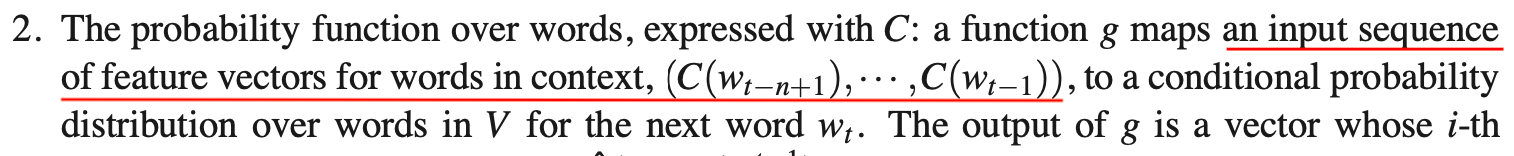

In [ ]:
Image('nnlm4.png',width=600)

### 3.1.1 - (2) 조건적 확률 분포를 이용하여 학습하기

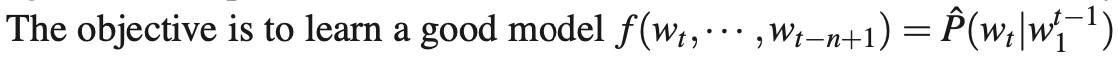

In [ ]:
Image('nnlm5.png',width=600)

- $\hat{P}(w_t|w_1^{t-1})$에서 오른 편의 것은 input이고, 왼편의 $w_t$는 target 이다.   
  
- (e.g.)가령, 문장 "호랑이도 제 말 하면 온다"를 위 같이 표현하면, 다음 같이 표현된다:  $\hat{P}$(온다 | 호랑이도 제 말 하면).   
  
  
여기서 이 문장의 역할은 오른 편의 words을 Input, 왼편의 word를 target으로 할 때, 우리의 모델이 이 target을 예측할 수 있게 학습시키는 데 이용되는 것이다.  
  
- 하지만 이 모델에서는 $w_1$~ $w_{t-1}$ 에 있는 모든 data를 다 고려하지 않고, 위의 $f(w_t,...,w_{t-n+1})$이 함의하는 것과 같이, 오직 $n-1$ 개의 미니 배치만을 input으로 고려한다. 

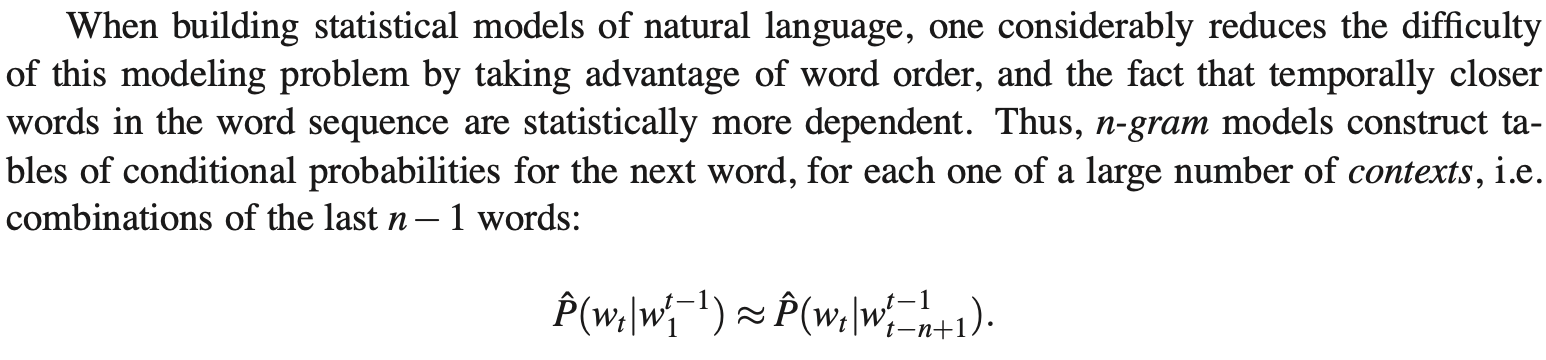

In [62]:
Image('nnlm7.png',width=600)

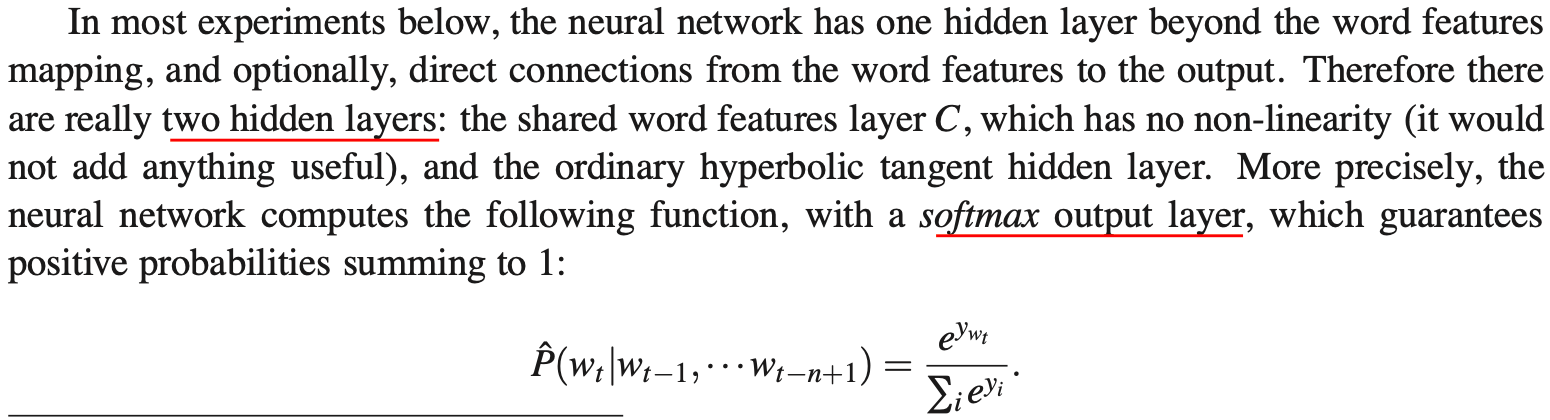

In [ ]:
Image('nnlm6.png',width=600)

In [ ]:
sentences = ["The engineering is based on the mathematics", "Many students dislike the mathematics", "But many students want to study the engineering"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = { w : i for i, w in enumerate(word_list)}

print('dict: ', word_dict)

def make_batch(sentences):

    input_batch=[]
    target_batch=[]
    word_set = []

    for sen in sentences:

        word = sen.split() # 하나의 문장에 대하여, 각 단어를 스플릿하여 리스트 형태로 저장
        input = [word_dict[n] for n in word[:-1]] # 한 문장 내에서 맨 마지막 word 직전까지만 출력. 그 뒤에 무엇이 올지(해당 문장 내에 맨 마지막 word)는 미정 상태로 둔다.
        target = word_dict[word[-1]] # 각 문장의 맨 마지막 글자만을 출력
        
        input_batch.append(input)
        target_batch.append(target)
        word_set.append(word)
        
    return print('\n\n(1) V 내에서 스플릿된 단어 집합:\n', word_set, '\n\n(2) 인풋 배치들에게 부여된 정수:\n',input_batch,'\n\n(3) 타깃 배치들에게 부여된 정수: \n', target_batch)

test = make_batch(sentences)
print(test)

dict:  {'the': 0, 'is': 1, 'on': 2, 'to': 3, 'students': 4, 'want': 5, 'engineering': 6, 'The': 7, 'But': 8, 'many': 9, 'study': 10, 'dislike': 11, 'mathematics': 12, 'based': 13, 'Many': 14}


(1) V 내에서 스플릿된 단어 집합:
 [['The', 'engineering', 'is', 'based', 'on', 'the', 'mathematics'], ['Many', 'students', 'dislike', 'the', 'mathematics'], ['But', 'many', 'students', 'want', 'to', 'study', 'the', 'engineering']] 

(2) 인풋 배치들에게 부여된 정수:
 [[7, 6, 1, 13, 2, 0], [14, 4, 11, 0], [8, 9, 4, 5, 3, 10, 0]] 

(3) 타깃 배치들에게 부여된 정수: 
 [12, 12, 6]
None


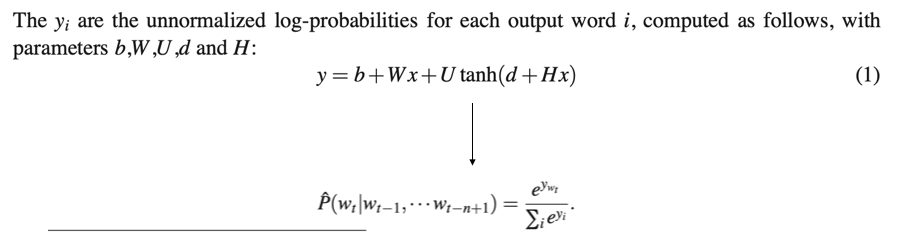

In [ ]:
Image('nnlm4.png',width=600)

이제 위 코드를 하나의 코드로 모은 뒤, Forward Pass를 수행해보자. 위 논문에서 제시하는 Forward Pass의 과정은 사실 위 식을 기술하는 것과 다름 없는 것이다.

In [60]:
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim


#미니배치 만들기

def make_batch():
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split() # space tokenizer
        input = [word_dict[n] for n in word[:-1]] # create (1~n-1) as input
        target = word_dict[word[-1]] 

        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch

## NPLM 모델

class NPLM(nn.Module):

    def __init__(self):

        super(NPLM, self).__init__()
        self.embedding_C = nn.Embedding(V,m) # "shared word features layer C, which has no non-linearity"
        self.H = nn.Linear((n-1)*m,h)
        self.U = nn.Linear(h,V)
        self.W = nn.Linear((n-1)*m,V) 
        
        self.activation = nn.LogSoftmax(dim=-1)

    def forward(self, X):

        # (1) X 구하기 #
        X_embedding = self.embedding_C(X)

        if len(X_embedding.shape) == 3: # batch mode
            batch_size, _, _ = X_embedding.shape
            X_embedding = X_embedding.view(batch_size,-1)

        else:
            X_embedding = X_embedding.view(-1)

        # (2) Forward Pass #

        o = self.H(X_embedding)
        a = torch.tanh(o)
        y = self.W(X_embedding) + self.U(a)

        return self.activation(y)

    #def backward(self, sf_y, cache):

    # backprop은 Pytorch에서 제공해주는 모듈loss.backward()를 사용한다.
    # 아래 main 함수에서 그것을 확인해보자.

if __name__=='__main__':

    n = 3 # step의 수
    h = 2 # 은닉층 개수 in the paper
    m = 2 # 임베딩 사이즈 in the paper

    sentences = ["i like dog", "i love coffee", "i hate milk",]

    word_list = " ".join(sentences).split() # 각 문장을 word로 스플릿 
    word_list = list(set(word_list)) # set -> 리스트화

    w2i_dict = {w:i for i,w in enumerate(word_list)}
    i2w_dict = {w2i_dict[w]: w for w in w2i_dict.keys()}
    
    # [1] w2i로 정보 나열

    print('[1] w2i_dict:\n',w2i_dict,'\n\n')
    
    # [2] V 구하기

    V = len(word_list) # Vocabulary (A set that consists in different words), V=7

    model = NPLM()
    
    criterion = nn.NLLLoss() # last activation이 LogSoftmax이면, Use the Negative Log Likelyhood Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    input_batch, target_batch = make_batch()
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    
    for epoch in range(5000):
        
        output = model(input_batch) # output : [batch_size, n_class], target_batch : [batch_size]
        
        loss = criterion(output, target_batch)
        
        if (epoch + 1) % 100 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        
        optimizer.zero_grad() # 
        loss.backward() # backprop을 파이토치에서 자동으로 계산해준다
        optimizer.step() # 업데이트

    # Predict
    _, predict_idx = torch.topk(model(input_batch),k=1,dim=-1)

    # Test
    print([sen.split()[:2] for sen in sentences], '->', [i2w_dict[i] for i in predict_idx.cpu().detach().numpy().reshape(-1)])




[1] w2i_dict:
 {'i': 0, 'like': 1, 'hate': 2, 'love': 3, 'dog': 4, 'coffee': 5, 'milk': 6} 


Epoch: 0100 cost = 1.152207
Epoch: 0200 cost = 0.796981
Epoch: 0300 cost = 0.561348
Epoch: 0400 cost = 0.401535
Epoch: 0500 cost = 0.286850
Epoch: 0600 cost = 0.204451
Epoch: 0700 cost = 0.146595
Epoch: 0800 cost = 0.106499
Epoch: 0900 cost = 0.078649
Epoch: 1000 cost = 0.059178
Epoch: 1100 cost = 0.045472
Epoch: 1200 cost = 0.035712
Epoch: 1300 cost = 0.028637
Epoch: 1400 cost = 0.023398
Epoch: 1500 cost = 0.019429
Epoch: 1600 cost = 0.016360
Epoch: 1700 cost = 0.013939
Epoch: 1800 cost = 0.011998
Epoch: 1900 cost = 0.010419
Epoch: 2000 cost = 0.009116
Epoch: 2100 cost = 0.008029
Epoch: 2200 cost = 0.007113
Epoch: 2300 cost = 0.006334
Epoch: 2400 cost = 0.005667
Epoch: 2500 cost = 0.005091
Epoch: 2600 cost = 0.004590
Epoch: 2700 cost = 0.004152
Epoch: 2800 cost = 0.003767
Epoch: 2900 cost = 0.003428
Epoch: 3000 cost = 0.003127
Epoch: 3100 cost = 0.002859
Epoch: 3200 cost = 0.002619
Epoch: 330

## 3.2 응용  
  
아래의 비교 수행을 통해 우리는 은닉층의 개수 $h$와 임베딩 사이즈인 $m$이 높을수록 더 정확하다는 것을 알 수 있다.

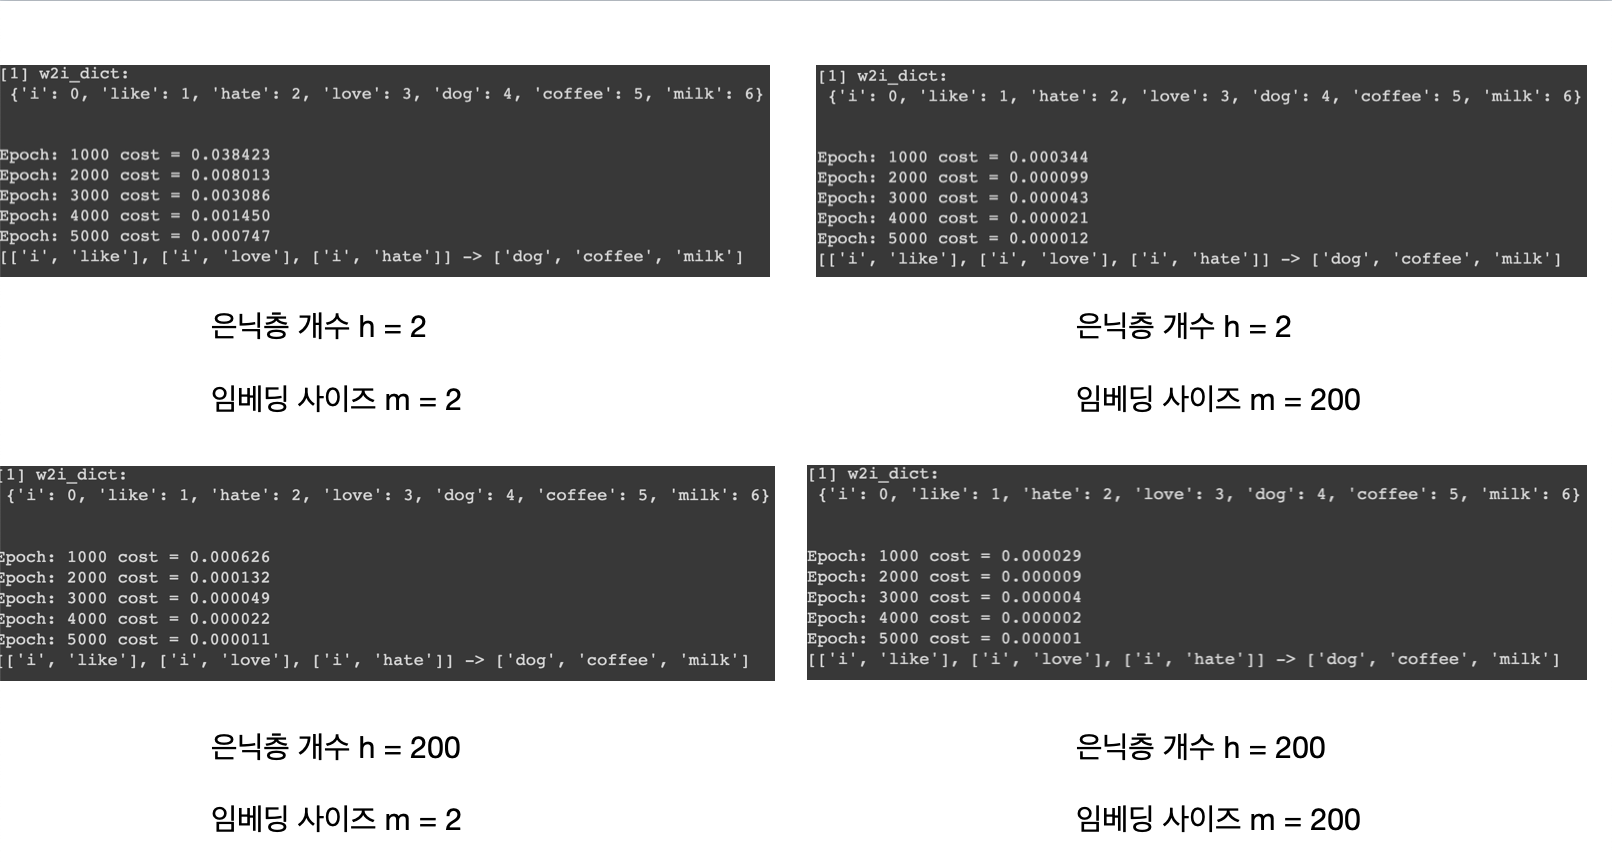

In [59]:
Image('nnlm9.png',width=800)

# Reference  
[1] Bengio, Yoshua, et al. "A neural probabilistic language model." Journal of machine learning research 3.Feb (2003): 1137-1155.  
[2] https://wikidocs.net/22647  
[3] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/03/29/NNLM/  
[4] https://www.districtdatalabs.com/nlp-research-lab-part-1-distributed-representations 분산 표현이 무엇인지에 대한 흥미로운 사고 실험을 소개한다.  

[5] https://colab.research.google.com/github/graykode/nlp-tutorial/blob/master/1-1.NNLM/NNLM.ipynb 참고 코드  

[6] https://wikidocs.net/16038 deepcopy에 대한 간명한 소개를 얻을 수 있다.  
[7] https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-nplm-f7d0f472ce68 본고에 대한 또 다른 국역 정리글  
[8] https://github.com/musicjae/intro_to_python/blob/master/pytorch_studying.ipynb 이곳에 본고를 이해할 때 요구되는 기본적인 파이토치 정리해두었다.  
